# Manual Feature Engineering

매뉴얼 feature engineering은 지루한 프로세스일 수 있으며(이 때문에 기능 툴과 함께 자동화된 feature engineering을 사용하는 것입니다!) 종종 도메인 전문지식에 의존합니다. <br>
저는 대출에 대한 도메인 지식이 제한되어 있고 무엇이 사람을 채무 불이행하게 만드는지 알기 때문에, 대신 저는 최대한 많은 정보를 최종 교육 자료로 가져오는데 집중할 것입니다. <br>
모델은 우리가 결정할 필요 없이 어떤 feature이 중요한지 선택할 것입니다. <br>
기본적으로, 우리의 접근 방식은 최대한 많은 feature을 만든 다음 사용할 수 있도록 모든 feature을 모델에 제공하는 것입니다.<br>
나중에 모델에서 가져온 feature이나 PCA와 같은 다른 기술을 사용하여 feature 축소를 수행할 수 있습니다.

매뉴얼 feature engineering 프로세스에는 많은 pandas 코드, 약간의 인내심, 그리고 많은 훌륭히 조작한 데이터가 필요합니다. 
자동화된 feature engineering 도구를 사용할 수 있게 되었지만, feature engineering은 좀 더 오랜 시간 동안 많은 데이터를 사용하여 수행해야 합니다.


In [2]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [3]:
# Read in bureau
bureau = pd.read_csv('./input/bureau.csv')
bureau.head()
bureau.shape

(1716428, 17)

In [4]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()
#previous_loan_counts.shape

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [68]:
# Join to the training dataframe
train = pd.read_csv('./input/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

0    0.139376
1         NaN
2    0.729567
3         NaN
4         NaN
Name: EXT_SOURCE_3, dtype: float64

# 1. Assessing Usefulness of New Variable with r value
새 변수가 유용한지 확인하기 위해 이 변수와 목표값 사이의 Pearson 상관 계수(r-값)를 계산할 수 있습니다. 이 값은 두 변수 사이의 선형 관계의 강도를 측정하고 범위는 -1(완벽하게 음수 선형)에서 +1(완벽하게 양의 선형) 사이입니다. r-값은 새 변수의 "유용성"에 대한 가장 좋은 척도는 아니지만 변수가 기계 학습 모델에 도움이 되는지 여부에 대한 첫 번째 근사치를 제공할 수 있습니다. 목표값에 대한 변수의 r-값이 클수록 이 변수의 변화가 목표값에 더 많은 영향을 미칠 수 있습니다. 따라서 목표값에 비해 절대값 r-값이 가장 큰 변수를 찾습니다.

## 1-1) Kernel Density Estimate Plots

커널 밀도 추정치 그림에서는 단일 변수의 분포를 보여 줍니다(평활 히스토그램으로 생각). 범주형 변수의 값에 따른 분포의 차이를 확인하기 위해 범주에 따라 분포의 색상을 다르게 지정할 수 있습니다. 예를 들어, TARGET = 1인지 0인지에 따라 색상이 지정된 이전_target_count의 커널 밀도 추정치를 표시할 수 있습니다. 그 결과 KDE는 대출금을 갚지 않은 사람(목표값 == 1)과 갚지 않은 사람(목표값 == 0) 사이의 변수 분포에서 유의한 차이를 보여줍니다. 이는 변수가 기계 학습 모델과 '관련성'이 있는지 여부를 나타내는 지표 역할을 할 수 있습니다.


In [6]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

랜덤 포레스트 및 그라데이션 부스팅 머신에 따라 가장 중요한 변수 중 하나인 EXT_SOURCE_3 변수를 사용하여 이 함수를 테스트할 수 있습니다.


The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


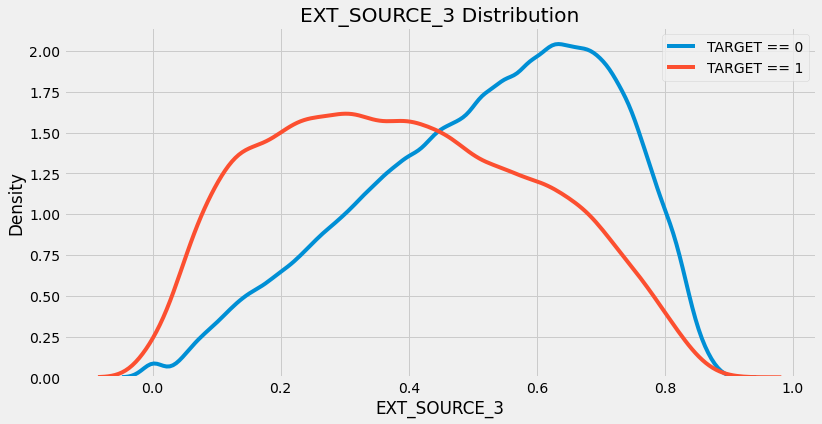

In [7]:
kde_target('EXT_SOURCE_3', train)

방금 만든 새로운 변수인데요, 다른 기관의 이전 대출 건수입니다.


The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


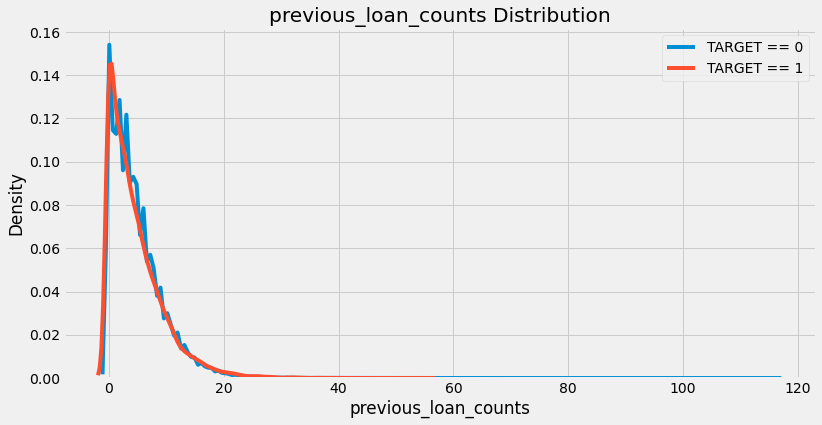

In [8]:
kde_target('previous_loan_counts', train)

이것만으로 이 변수가 중요한지 알 수 없습니다. 상관 계수가 매우 약하고 분포에서 눈에 띄는 차이가 거의 없습니다.

FBI 데이터 프레임에서 몇 가지 변수를 더 만들어 보겠습니다. 정보국 데이터 프레임에 있는 모든 숫자 열의 평균, 최소 및 최대값을 구하겠습니다.


# 2. Aggregating Numeric Columns

정보국 데이터 프레임의 숫자 정보를 설명하기 위해 모든 숫자 열에 대한 통계를 계산할 수 있습니다. 이를 위해 클라이언트 ID별로 그룹화하고 그룹화된 데이터 프레임을 집계한 후 결과를 교육 데이터에 다시 병합합니다. agg 함수는 연산이 유효한 것으로 간주되는 숫자 열의 값만 계산합니다. 우리는 'mean', 'max', 'min', 'sum'을 사용하겠지만 어떤 함수도 여기에 전달될 수 있습니다. 우리가 직접 함수를 작성하여 애그콜에 사용할 수도 있습니다.


In [69]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [71]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [ ]:
train = pd.read_csv
train_agg = train.group_by('id').agg(['min']).reset_index()

columns = ['id']
for i in train_agg.columns.levels[0]:
    for j in train_agg.columns.levels[1][:-1]:
        columns.append("brue_%s_%s"% (i, j))
train_agg.columns = columns
train_agg

In [11]:
bureau_agg.columns.levels

FrozenList([['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'SK_ID_CURR'], ['count', 'mean', 'max', 'min', 'sum', '']])

In [12]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


이제 이전과 같이 교육 데이터와 병합하면 됩니다.


In [13]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


# 3. Correlations of Aggregated Values with Target

우리는 모든 새로운 값과 목표값의 상관관계를 계산할 수 있습니다. 다시 말해, 모델링에 중요한 변수의 근사치로 사용할 수 있습니다.



In [14]:
# List of new correlations
new_corrs = []

for col in columns:
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))

아래 코드에서는 정렬된 파이썬 함수를 사용하여 크기(절대값)별로 상관관계를 정렬합니다. 또한 또 다른 중요한 파이썬 연산인 익명 람다 함수를 사용합니다.


In [15]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998116),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301037),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968673),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392085),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020544),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.053199625857586336),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973074),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111597),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835404),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730204),
 ('bureau_DAYS_CREDIT_sum', 0.041999824814846765),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306015),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632896),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332553)]

목표값과 유의한 상관 관계가 있는 새 변수가 없습니다. 상관 관계가 가장 높은 변수 bro_의 KDE 그림을 볼 수 있습니다.절대 크기 상관 관계 측면에서 목표값이 있는 DAYS_Credit_mean입니다.


The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


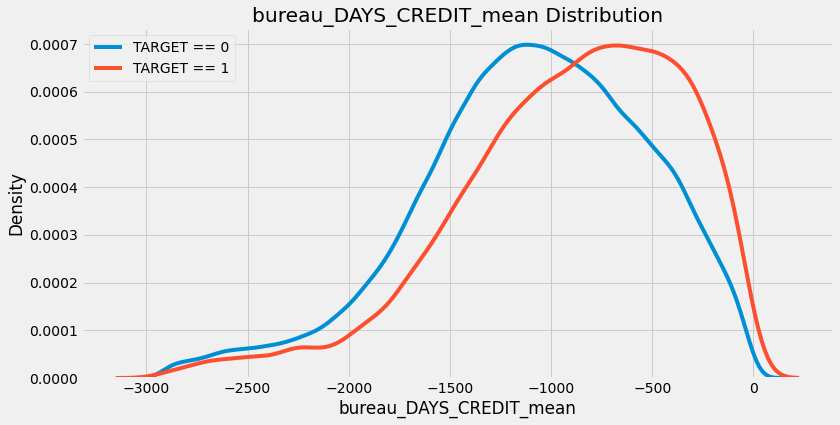

In [16]:
kde_target('bureau_DAYS_CREDIT_mean', train)

이 칼럼의 정의는 "고객이 현재 신청하기 며칠 전에 신용 조회를 신청했는가"입니다.

제가 해석한 바로는 이전 대출이 홈 크레딧에 대출 신청 전 신청된 일수입니다.

따라서 마이너스 숫자가 크면 대출이 현재 대출 신청 전에 더 많았음을 나타냅니다.

우리는 이 변수의 평균과 과거에 대출을 더 신청한 고객들이 잠재적으로 홈 크레딧에서 대출을 상환할 가능성이 더 높다는 목표 의미 사이의 극히 약한 긍정적 관계를 봅니다. 하지만 이렇게 약한 상관관계에서는 신호와 마찬가지로 노이즈일 가능성이 높습니다.

### The Multiple Comparisons Problem

변수가 많을 때, 우리는 변수 중 일부는 순수 우연에 의해 상관관계가 있을 것으로 예상하는데, 이는 다중 비교라고 알려져 있습니다. 우리는 수백 개의 특징을 만들 수 있고, 일부는 단순히 데이터의 무작위 노이즈 때문에 대상과 공동화될 것입니다. 그런 다음 모델이 훈련할 때 훈련 세트의 목표값과 관계가 있다고 생각하기 때문에 이러한 변수에 과도하게 적합될 수 있지만 이것이 반드시 검정 집합으로 일반화되는 것은 아닙니다. 우리가 특징을 만들 때 고려해야 할 많은 사항들이 있습니다!


# 2. Function for Numeric Aggregations


In [17]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var] # 'SK_ID_CURR'
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    columns = [group_var]

    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [18]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


이 기능이 의도한 대로 작동하는지 확인하기 위해서는 우리가 직접 만든 집계된 데이터 프레임과 비교해야 합니다.


In [19]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


만약 우리가 그 값들을 조사한다면, 우리는 그것들이 동등하다는 것을 발견합니다. 우리는 이 함수를 다른 데이터 프레임의 숫자 통계를 계산하는 데 사용할 수 있을 것입니다. 기능을 사용하면 일관된 결과를 얻을 수 있고 미래에 해야 할 일의 양을 줄일 수 있습니다!


### Correlation Function
다음으로 넘어가기 전에 대상과의 상관관계를 함수로 계산하기 위한 코드를 만들 수도 있습니다.


In [20]:
def target_corrs(df):

    corrs = []

    for col in df.columns:
        print(col)
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col])

            corrs.append((col, corr))
            
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

# 4. Categorical Variables

이제 숫자 열에서 범주형 열로 이동합니다. 이것들은 이산 문자열 변수이기 때문에 숫자 변수에만 적용되는 평균, 최대와 같은 통계만 계산할 수는 없습니다. 대신, 우리는 각 범주형 변수 내에서 각 범주의 값 카운트를 계산하는 것에 의존할 것입니다. 예를 들어, 다음과 같은 데이터 프레임이 있습니다.


먼저 범주형 열(dtype == 'object')만 사용하여 데이터 프레임을 원핫 인코딩합니다.


In [21]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [22]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [23]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [24]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [25]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [26]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train.shape

(307511, 229)

In [28]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4-1) Function to Handle Categorical Variables



In [29]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [30]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## Applying Operations to another dataframe


In [31]:
bureau_balance = pd.read_csv('./input/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [32]:
# bureau_balance 카테고리 변환
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


이제 하나의 숫자 열을 처리할 수 있습니다. MONSTS_BALANCE 열에는 "적용일을 기준으로 한 균형 월"이 있습니다. 이 값이 숫자 변수만큼 반드시 중요한 것은 아닐 수 있으며, 향후 작업에서는 시간 변수로 고려할 수 있습니다. 지금은 이전과 동일한 집계 통계만 계산하면 됩니다.


In [33]:
# bureau_balance 숫자 변환
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [34]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [35]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


# Putting the Functions Together


In [36]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

7409

In [37]:
# Read in new copies of all the dataframes
train = pd.read_csv('./input/application_train.csv') # (307511, 122), (307511, 106), (307511, 16)
bureau = pd.read_csv('./input/bureau.csv') # (1716428, 17), (1716428, 14), (1716428, 3)
bureau_balance = pd.read_csv('./input/bureau_balance.csv') # (27299925, 3), (27299925, 2), (27299925, 1)

In [38]:
bureau.tail()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN
1716427,246829,5057778,Closed,currency 1,-463,0,NaN,-387.0,NaN,0,22500.00,0.0,NaN,0.0,Microloan,-387,NaN


### Counts of Bureau Dataframe(Bureau:숫자형)


In [39]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Aggregated Stats of Bureau Dataframe(Bureau:카테고리형)


In [40]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Value counts of Bureau Balance dataframe by loan(Bureau_Balance:숫자형)


In [41]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### Aggregated stats of Bureau Balance dataframe by loan(Bureau_Balance:카테고리형)


In [42]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


### Aggregated Stats of Bureau Balance by Client(Bureau_Balance : 숫자+카테고리)


In [43]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [44]:
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

# Insert Computed Features into Training Data


In [45]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [46]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [47]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


# 3. Feature Engineering Outcomes

그 모든 작업이 끝난 후, 이제 우리가 만든 변수를 살펴보려고 합니다. 결측값의 백분율, 목표값과의 변수 상관관계 및 다른 변수와의 상관관계를 확인할 수 있습니다. 변수들 간의 상관관계는 우리가 공선형 변수들, 즉 서로 높은 상관관계가 있는 변수들을 가지고 있는지를 보여줄 수 있습니다. 두 변수가 모두 있으면 중복될 수 있기 때문에 한 쌍의 동일 선형 변수를 제거하고자 하는 경우가 많습니다. 결측값의 백분율을 사용하여 존재하지 않는 대부분의 값을 가진 형상을 제거할 수도 있습니다. 피쳐 수를 줄이면 모델이 교육 중에 학습하는 데 도움이 되고 테스트 데이터로 더 잘 일반화할 수 있기 때문에 피쳐 선택은 앞으로 중요한 초점이 될 것입니다. "차원의 곡선"은 너무 많은 피쳐(차원의 너무 높음)로 인해 발생하는 문제에 주어진 이름입니다. 변수의 수가 증가함에 따라 이러한 변수와 목표값 사이의 관계를 학습하는 데 필요한 데이터 점의 수는 기하급수적으로 증가합니다.


피쳐 선택은 모델이 학습하고 테스트 세트에 더 잘 일반화하는 데 도움이 되는 변수를 제거하는 프로세스입니다. 유용한 변수는 보존하면서 쓸모없는/중복된 변수는 제거하는 것이 목적입니다. 이 프로세스에 사용할 수 있는 도구는 여러 가지가 있지만 이 노트북에서는 결측값 비율이 높은 열과 서로 상관 관계가 높은 변수를 제거하는 방법을 고수할 것입니다. 나중에 Gradient Boosting Machine 또는 Random Forest와 같은 모델에서 반환된 피쳐 가져오기를 사용하여 피쳐 선택을 수행할 수 있습니다.


## 3-1) Missing Values
중요한 고려 사항은 데이터 프레임의 결측치입니다. 결측값이 너무 많은 열을 삭제해야 할 수 있습니다.


In [48]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [49]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


In [50]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

### 3-1-1) Calculate Information for Testing Data


In [51]:
test = pd.read_csv('./input/application_test.csv')

test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


테스트 및 교육 데이터 프레임을 정렬해야 합니다. 즉, 동일한 열을 가지도록 열을 일치시켜야 합니다. 여기서 문제가 되지는 않지만 변수를 한 번 핫 인코딩할 때는 데이터 프레임이 동일한 열을 가지도록 정렬해야 합니다.


In [52]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [53]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


이제 데이터 프레임에 동일한 열이 있습니다(교육 데이터의 TARGET 열 제외). 
즉, 교육 및 테스트 데이터 프레임 모두에서 동일한 열을 확인해야 하는 기계 학습 모델에서 사용할 수 있습니다.
이제 삭제해야 할 열을 파악할 수 있도록 검정 데이터에서 결측값의 백분율을 살펴보겠습니다.


In [54]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [55]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [56]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [57]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

결측치가 90%를 초과하는 열이 없기 때문에 이 라운드에서는 열을 제거하지 못했습니다. 치수 축소를 위해 다른 피쳐 선택 방법을 적용해야 할 수도 있습니다.
그러면 교육 데이터와 테스트 데이터를 모두 저장할 것입니다. 누락된 열을 삭제하기 위해 다른 백분율을 시도하고 결과를 비교하는 것이 좋습니다.


In [58]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

## 3-2) Correlations


먼저 변수와 대상의 상관관계를 살펴보겠습니다. 우리가 생성한 모든 변수에서 교육 데이터에 이미 존재하는 변수보다 더 큰 상관 관계를 가질 수 있습니다(응용프로그램에서).


In [59]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [60]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [61]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


대상과의 상관관계가 가장 높은 변수(상관성이 1인 대상 제외)는 우리가 생성한 변수입니다. 그러나 변수가 상관관계가 있다고 해서 유용하다는 것은 아니며, 수백 개의 새로운 변수를 생성하면 일부는 단순히 무작위 노이즈 때문에 대상과 상관 관계가 있다는 것을 기억해야 합니다.

회의적으로 상관 관계를 살펴보면 새로 생성된 변수 중 몇 개가 유용할 수 있습니다. 변수의 "유용성"을 평가하기 위해 모형에서 반환되는 피쳐 중요도를 살펴보겠습니다. 호기심을 위해(그리고 함수를 이미 작성했기 때문에) 새로 생성된 두 변수에 대한 kde 그림을 만들 수 있습니다.

In [62]:
# kde_target(var_name='client_bureau_balance_counts_mean', df=train) error

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


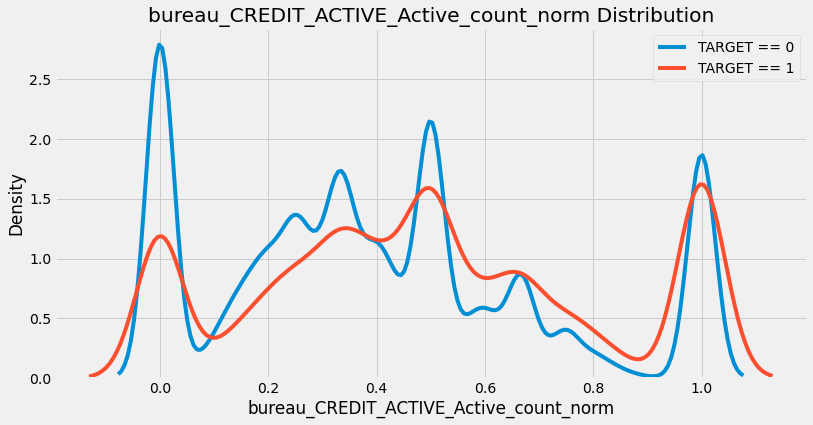

In [63]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

음, 이 배포판은 어디에나 있습니다. 이 변수는 CREMIT_ACTIVE 값이 활성인 이전 대출 수를 고객에 대한 총 이전 대출 수로 나눈 값을 나타냅니다. 여기 상관관계가 너무 약해서 결론을 내려서는 안 될 것 같아요!

### 3-2-1) Collinear Variables
변수와 목표 변수의 상관관계뿐만 아니라 각 변수와 다른 변수의 상관관계도 계산할 수 있습니다. 이를 통해 데이터에서 제거해야 할 높은 공선형 변수가 있는지 확인할 수 있습니다.
다른 변수와의 상관 관계가 0.8보다 큰 변수를 살펴보겠습니다.


In [107]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [118]:
corrs

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum,TARGET
TARGET,-0.002108,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,...,-0.033292,-0.030919,-0.014557,-0.008445,0.010669,0.000408,0.001110,-0.001056,0.009862,1.000000
bureau_DAYS_CREDIT_mean,0.003636,0.026094,-0.008837,-0.084393,-0.066503,-0.086089,-0.019976,0.203135,-0.043686,0.096894,...,-0.300980,-0.307838,-0.157844,-0.113809,-0.026203,0.014804,-0.047574,0.058192,-0.013751,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.003236,0.021236,-0.025563,-0.083456,-0.058436,-0.085685,-0.013693,0.200788,-0.041321,0.091993,...,-0.301008,-0.307970,-0.157790,-0.245166,-0.128957,0.014839,-0.047631,0.058225,-0.061936,0.089038
DAYS_BIRTH,-0.001500,0.330938,0.027261,-0.055436,0.009445,-0.053442,-0.029582,1.000000,-0.615864,0.331912,...,-0.057868,-0.074272,-0.016743,-0.025157,-0.008141,-0.009988,-0.032401,0.014397,-0.009433,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.001229,0.013221,0.016527,-0.021280,-0.037859,-0.026544,0.015857,0.116114,-0.049473,0.046167,...,-0.043370,-0.097456,0.012146,-0.045975,-0.074026,0.139934,0.034106,0.156642,-0.007553,0.077356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.000463,-0.013071,-0.016815,0.021459,0.037671,0.026702,-0.017241,-0.115926,0.050521,-0.046846,...,0.038145,0.092723,-0.015712,0.044342,0.073930,-0.142027,-0.036420,-0.158011,0.006860,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.004068,-0.026412,0.023685,0.071355,0.071230,0.073737,0.027155,-0.160568,0.033628,-0.076290,...,0.385175,0.367959,0.222072,0.278595,0.045621,0.004090,0.056408,-0.028684,0.023920,-0.080193
EXT_SOURCE_1,0.000082,-0.138470,0.026232,0.168429,0.119398,0.175502,0.099997,-0.600610,0.289848,-0.181095,...,0.066610,0.097395,0.002111,0.035855,0.010779,0.021582,0.061695,-0.021389,0.015403,-0.155317
EXT_SOURCE_2,0.002342,-0.018015,0.060925,0.131228,0.125804,0.139367,0.198924,-0.091996,-0.020767,-0.059913,...,0.055292,0.055341,0.024821,0.024739,-0.000163,0.032212,0.034839,0.010258,0.012558,-0.160472


In [109]:
for col in corrs:
    print(col)

SK_ID_CURR
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTM

In [110]:
list(corrs.index[corrs[col] > threshold])

['TARGET']

이러한 상관 관계가 높은 변수 쌍에 대해 두 변수 중 하나만 제거하려고 합니다. 다음 코드는 각 쌍 중 하나만 추가하여 제거할 변수 집합을 만듭니다.


In [65]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items(): # 칼럼명, 상관계수
    # Keep track of columns already examined
    cols_seen.append(key) 
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


In [103]:
above_threshold_vars

{'SK_ID_CURR': ['SK_ID_CURR'],
 'CNT_CHILDREN': ['CNT_CHILDREN', 'CNT_FAM_MEMBERS'],
 'AMT_INCOME_TOTAL': ['AMT_INCOME_TOTAL'],
 'AMT_CREDIT': ['AMT_CREDIT', 'AMT_GOODS_PRICE'],
 'AMT_ANNUITY': ['AMT_ANNUITY'],
 'AMT_GOODS_PRICE': ['AMT_CREDIT', 'AMT_GOODS_PRICE'],
 'REGION_POPULATION_RELATIVE': ['REGION_POPULATION_RELATIVE'],
 'DAYS_BIRTH': ['DAYS_BIRTH'],
 'DAYS_EMPLOYED': ['DAYS_EMPLOYED'],
 'DAYS_REGISTRATION': ['DAYS_REGISTRATION'],
 'DAYS_ID_PUBLISH': ['DAYS_ID_PUBLISH'],
 'OWN_CAR_AGE': ['OWN_CAR_AGE'],
 'FLAG_MOBIL': ['FLAG_MOBIL'],
 'FLAG_EMP_PHONE': ['FLAG_EMP_PHONE'],
 'FLAG_WORK_PHONE': ['FLAG_WORK_PHONE'],
 'FLAG_CONT_MOBILE': ['FLAG_CONT_MOBILE'],
 'FLAG_PHONE': ['FLAG_PHONE'],
 'FLAG_EMAIL': ['FLAG_EMAIL'],
 'CNT_FAM_MEMBERS': ['CNT_CHILDREN', 'CNT_FAM_MEMBERS'],
 'REGION_RATING_CLIENT': ['REGION_RATING_CLIENT_W_CITY',
  'REGION_RATING_CLIENT'],
 'REGION_RATING_CLIENT_W_CITY': ['REGION_RATING_CLIENT_W_CITY',
  'REGION_RATING_CLIENT'],
 'HOUR_APPR_PROCESS_START': ['HOUR_A

In [102]:
above_threshold_vars.items()

dict_items([('SK_ID_CURR', ['SK_ID_CURR']), ('CNT_CHILDREN', ['CNT_CHILDREN', 'CNT_FAM_MEMBERS']), ('AMT_INCOME_TOTAL', ['AMT_INCOME_TOTAL']), ('AMT_CREDIT', ['AMT_CREDIT', 'AMT_GOODS_PRICE']), ('AMT_ANNUITY', ['AMT_ANNUITY']), ('AMT_GOODS_PRICE', ['AMT_CREDIT', 'AMT_GOODS_PRICE']), ('REGION_POPULATION_RELATIVE', ['REGION_POPULATION_RELATIVE']), ('DAYS_BIRTH', ['DAYS_BIRTH']), ('DAYS_EMPLOYED', ['DAYS_EMPLOYED']), ('DAYS_REGISTRATION', ['DAYS_REGISTRATION']), ('DAYS_ID_PUBLISH', ['DAYS_ID_PUBLISH']), ('OWN_CAR_AGE', ['OWN_CAR_AGE']), ('FLAG_MOBIL', ['FLAG_MOBIL']), ('FLAG_EMP_PHONE', ['FLAG_EMP_PHONE']), ('FLAG_WORK_PHONE', ['FLAG_WORK_PHONE']), ('FLAG_CONT_MOBILE', ['FLAG_CONT_MOBILE']), ('FLAG_PHONE', ['FLAG_PHONE']), ('FLAG_EMAIL', ['FLAG_EMAIL']), ('CNT_FAM_MEMBERS', ['CNT_CHILDREN', 'CNT_FAM_MEMBERS']), ('REGION_RATING_CLIENT', ['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT']), ('REGION_RATING_CLIENT_W_CITY', ['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT']), ('HOUR_

교육 및 테스트 데이터 세트 모두에서 이러한 열을 제거할 수 있습니다. 이러한 변수를 제거한 후 이러한 변수를 유지하는 성능(앞서 저장한 원시 csv 파일)을 비교해야 합니다.


In [66]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [67]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

# 4. Modeling


이러한 새로운 데이터 세트의 성능을 실제로 테스트하기 위해 이 데이터셋을 머신러닝에 사용해 보겠습니다. 여기서는 다른 노트북에서 개발한 기능을 사용하여 기능(상관성이 높은 변수가 제거된 원시 버전)을 비교합니다. 우리는 이런 종류의 실험을 할 수 있고, 경쟁사에 제출되었을 때 이 기능에 있는 애플리케이션 데이터들의 성능만 제어할 수 있을 것입니다. 이 성능을 이미 기록했으므로 제어 및 두 가지 테스트 조건을 나열할 수 있습니다.

모든 데이터셋에 대해 정확한 하이퍼 파라미터와 함께 아래 표시된 모델을 사용하십시오.

컨트롤: 응용 프로그램 파일의 데이터만 해당됩니다.
테스트 1: 응용 프로그램 파일의 데이터와 bureau_balance 파일의 모든 데이터가 기록됩니다.
테스트 2: 애플리케이션 파일의 데이터와 상관 관계가 높은 변수가 있는 bure_balance 파일을 모두 제거합니다.
    

In [74]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [87]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [80]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

Control
실험의 첫 번째 단계는 관리 상태를 설정하는 것입니다. 이를 위해 위에서 정의한 함수(그라디언트 부스팅 머신 모델 구현)와 단일 메인 데이터 소스(애플리케이션)를 사용합니다.


In [81]:
train_control = pd.read_csv('./input/application_train.csv')
test_control = pd.read_csv('./input/application_test.csv')

다행히도 시간을 들여 함수를 작성하면 사용이 간단합니다(이 노트에 중심 테마가 있는 경우 함수를 사용하여 작업을 단순화하고 재현할 수 있습니다!). 위의 함수는 경쟁업체에 업로드할 수 있는 제출 데이터 프레임, 기능 중요도의 fi 데이터 프레임, 검증 및 테스트 성능이 있는 메트릭 데이터 프레임을 반환합니다.


In [88]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755594	valid's binary_logloss: 0.544951
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_logloss: 0.564505
[200]	train's auc: 0.798947	train's binary_logloss: 0.547854	valid's auc: 0.757823	valid's binary_logloss: 0.562315
[200]	train's auc: 0.798357	train's binary_logloss: 0.548311	valid's auc: 0.758237	valid's binary_logloss: 0.564466


In [89]:
metrics

,fold,train,valid
0,0,0.815791,0.755755
1,1,0.811912,0.758533
2,2,0.811252,0.763822
3,3,0.805899,0.758345
4,4,0.807459,0.758535
5,overall,0.810463,0.759002


교육 점수가 검증 점수보다 높기 때문에 관리 기능이 약간 과적합됩니다. 이 문제는 정규화를 살펴볼 때 이후의 노트북에서 해결할 수 있습니다(이 모델에서는 이미 reg_lambda 및 reg_alpha와 조기 중지를 사용하여 일부 정규화를 수행하고 있습니다).

다른 함수인 플롯_feature_imports를 사용하여 피쳐의 중요성을 시각화할 수 있습니다. 피쳐 중요도는 피쳐를 선택할 때 유용할 수 있습니다.


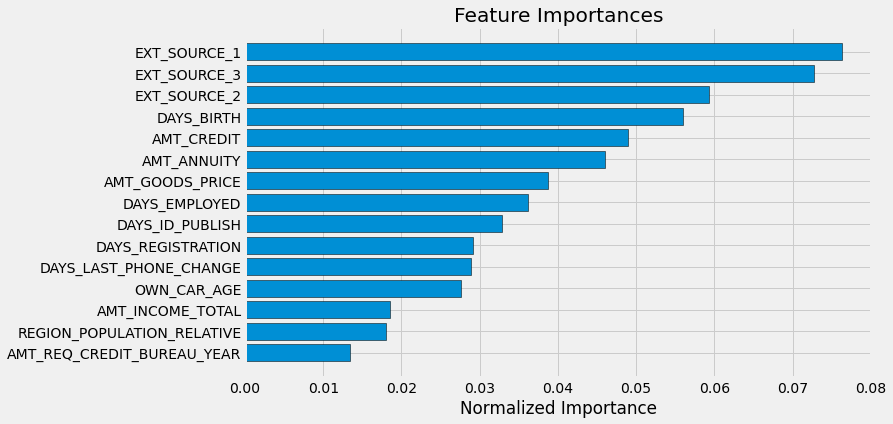

In [91]:
fi_sorted = plot_feature_importances(fi)

In [92]:
submission.to_csv('control.csv', index = False)

The control scores 0.745 when submitted to the competition.



Test One

첫 번째 테스트를 진행하겠습니다. 우리는 대부분의 일을 하는 함수에 데이터를 전달하기만 하면 됩니다.


In [93]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755594	valid's binary_logloss: 0.544951
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_logloss: 0.564505
[200]	train's auc: 0.798947	train's binary_logloss: 0.547854	valid's auc: 0.757823	valid's binary_logloss: 0.562315
[200]	train's auc: 0.798357	train's binary_logloss: 0.548311	valid's auc: 0.758237	valid's binary_logloss: 0.564466


In [94]:
metrics_raw

,fold,train,valid
0,0,0.815791,0.755755
1,1,0.811912,0.758533
2,2,0.811252,0.763822
3,3,0.805899,0.758345
4,4,0.807459,0.758535
5,overall,0.810463,0.759002


이 숫자에 기초하여, 조작된 형상은 대조군보다 더 나은 성능을 발휘합니다. 그러나 이 더 나은 검증 성능이 테스트 데이터로 전송되는지 여부는 예측 결과를 리더보드에 제출해야 합니다.


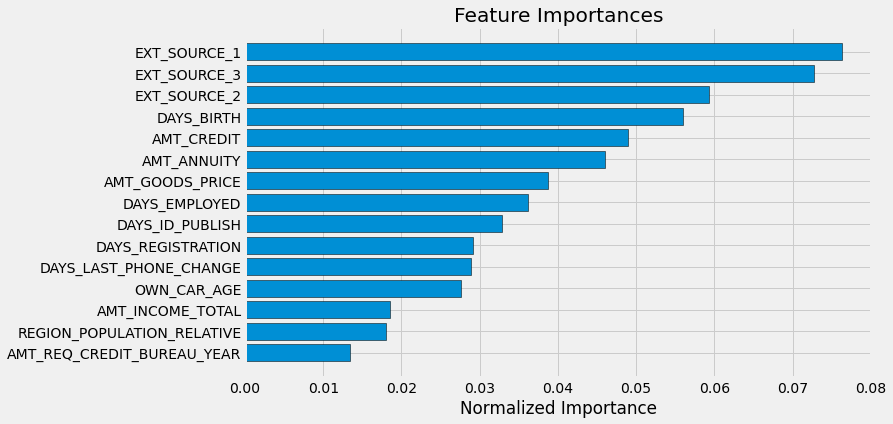

In [95]:
fi_raw_sorted = plot_feature_importances(fi_raw)

특징의 성향을 살펴본 결과, 우리가 구축한 몇 가지 특징들이 가장 중요한 것들 중 하나인 것 같습니다. 이 노트에서 우리가 만든 상위 100가지 가장 중요한 기능 중 몇 퍼센트를 찾아보겠습니다. 그러나 기존 기능과 비교하기보다는 원핫 인코딩된 기존 기능과 비교해야 합니다. 이것들은 이미 fi에 기록되어 있습니다.


In [96]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 0.00


100대 특집 중 절반 이상이 저희가 만든 작품이에요! 그것은 우리가 노력한 모든 것이 보람 있었다는 자신감을 주어야 합니다.


In [97]:
submission_raw.to_csv('test_one.csv', index = False)

Test one scores 0.759 when submitted to the competition.



Test Two

쉬웠으니까 한 번 더 달려보죠! 이전과 동일하지만 높은 공선형 변수를 제거합니다.



In [98]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
[200]	train's auc: 0.807062	train's binary_logloss: 0.539926	valid's auc: 0.761756	valid's binary_logloss: 0.555974
[200]	train's auc: 0.807403	train's binary_logloss: 0.539835	valid's auc: 0.762487	valid's binary_logloss: 0.556178
[200]	train's auc: 0.806206	train's binary_logloss: 0.541195	valid's auc: 0.766958	valid's binary_logloss: 0.557491
[400]	train's auc: 0.83864	train's binary_logloss: 0.508571	valid's auc: 0.767385	valid's binary_logloss: 0.536782
[200]	train's auc: 0.806561	train's binary_logloss: 0.540767	valid's auc: 0.763307	valid's binary_logloss: 0.556131
[200]	train's auc: 0.807104	train's binary_logloss: 0.540208	valid's auc: 0.760759	valid's binary_logloss: 0.557689


In [99]:
metrics_corr

,fold,train,valid
0,0,0.819890,0.762222
1,1,0.816296,0.762811
2,2,0.835801,0.767546
3,3,0.807812,0.763487
4,4,0.823635,0.761030
5,overall,0.820687,0.763372


이러한 결과는 관리 수준보다는 낫지만 원시 특징보다는 약간 낮습니다.

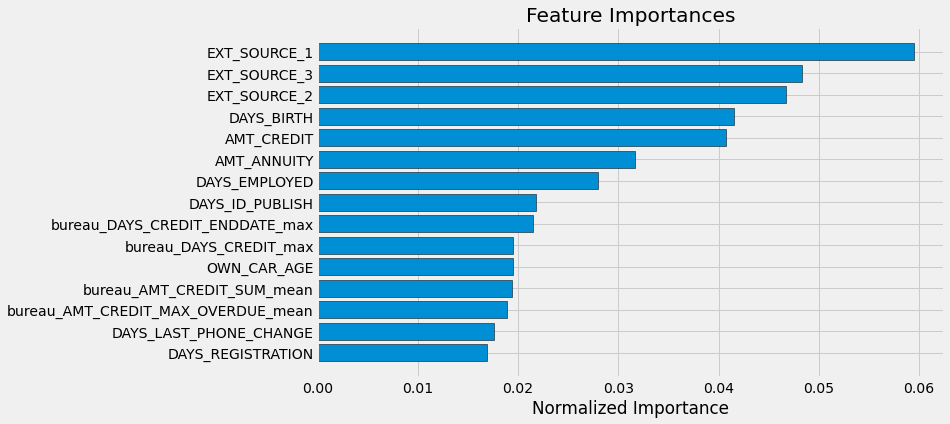

In [100]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [101]:
submission_corrs.to_csv('test_two.csv', index = False)

Test Two scores 0.753 when submitted to the competition.


Results

그렇게 노력한 결과, 추가 정보를 포함하면 실적이 향상되었다고 할 수 있습니다! 이 모델은 데이터에 최적화되어 있지 않지만 계산된 기능을 사용할 때 원래 데이터 세트에 비해 눈에 띄게 개선되었습니다. 공식적으로 공연 내용을 요약해 보겠습니다.

우리의 모든 노력은 원본 테스트 데이터에 비해 0.014 ROC AUC가 약간 개선된 것으로 해석됩니다. 높은 공선형 변수를 제거하면 성능이 약간 저하되므로 다른 피쳐 선택 방법을 고려하고자 합니다. 또한 우리가 만든 기능 중 일부는 모델에 따라 가장 중요한 기능 중 하나라고 할 수 있습니다.

이런 대회에서는 이 정도 크기만 개선해도 리더보드의 100분의 1을 올릴 수 있습니다. 이 노트와 같이 수많은 작은 개선을 통해 우리는 점점 더 좋은 성과를 낼 수 있습니다. 저는 다른 사람들이 여기의 결과를 활용하여 스스로 개선하도록 격려하며, 제가 다른 사람들을 돕기 위해 취하는 조치들을 계속 기록할 것입니다.

